<a href="https://colab.research.google.com/github/pichuu12/All-projects-and-Internship-tasks/blob/main/food_classification_project/Food_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FOOD CLASSIFICATION - 101 categories


*   The goal of the project is to beat the DeepFood paper published in 2016 which categorizes 101 food categories with an accuracy of 77.4%

Dataset - [Drive Link](https://drive.google.com/file/d/1mdoM82J4u5kdrHN0rbE7eWpjDQhdXKNl/view?usp=sharing)


## Training and Testing Model with only 10% of original dataset

In [ ]:
!nvidia-smi

Sun Mar 12 07:25:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    31W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Importing helper functions

In [ ]:
#!wget https://github.com/pichuu12/All-projects-and-Internship-tasks/blob/main/helper_functions.py

In [ ]:
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

def load_and_prep_image(filename, img_shape=224, scale=True):
  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] 
  n_classes = cm.shape[0] 
  
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) 
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), 
         yticks=np.arange(n_classes), 
         xticklabels=labels, 
         yticklabels=labels)
  
 
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  threshold = (cm.max() + cm.min()) / 2.

 
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  if savefig:
    fig.savefig("confusion_matrix.png")
  
def pred_and_plot(model, filename, class_names):
  img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))
  
  if len(pred[0]) > 1: 
    pred_class = class_names[pred.argmax()] 
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] 

  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]
    
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


import zipfile

def unzip_data(filename):
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

import os

def walk_through_dir(dir_path):
 
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

### Getting dataset from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/food_dataset/101_food_classes_10_percent.zip

Streaming output truncated to the last 5000 lines.
  inflating: 101_food_classes_10_percent/train/beet_salad/2450020.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/550087.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/3132380.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/44885.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/1967147.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/1422905.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/1380319.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/1336726.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/2808614.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/66574.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/3537144.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/3165387.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/3391241.jpg  
  inflating: 101_f

In [ ]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [ ]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/donuts'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ravioli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baby_back_ribs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cup_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beignets'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/greek_salad'.
There are 0 directories and 75 images in '101_food_clas

### Setting up datasets

In [ ]:
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) 

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
#checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, 
                                                         monitor="val_accuracy", 
                                                         save_best_only=True) 

### Data Augmentation

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2), 
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2), 
], name="data_augmentation")

### Base model setup

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer") 
x = data_augmentation(inputs)
x = base_model(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) 
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) 
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), 
                                           callbacks=[checkpoint_callback]) 

Epoch 1/5


237/237 [==============================] - 161s 607ms/step - loss: 3.3735 - accuracy: 0.2741 - val_loss: 2.5348 - val_accuracy: 0.4203
Epoch 2/5
237/237 [==============================] - 115s 480ms/step - loss: 2.2000 - accuracy: 0.4976 - val_loss: 2.0855 - val_accuracy: 0.4881
Epoch 3/5
237/237 [==============================] - 120s 505ms/step - loss: 1.8277 - accuracy: 0.5596 - val_loss: 1.9270 - val_accuracy: 0.5058
Epoch 4/5
237/237 [==============================] - 92s 386ms/step - loss: 1.6058 - accuracy: 0.6065 - val_loss: 1.8194 - val_accuracy: 0.5289
Epoch 5/5
237/237 [==============================] - 84s 353ms/step - loss: 1.4487 - accuracy: 0.6432 - val_loss: 1.7785 - val_accuracy: 0.5310


In [ ]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 71s 89ms/step - loss: 1.5865 - accuracy: 0.5830


[1.5864819288253784, 0.5830098986625671]

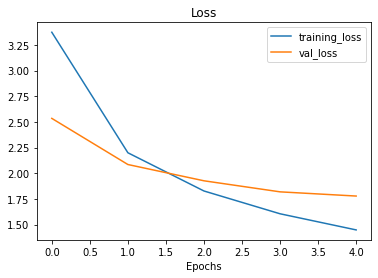

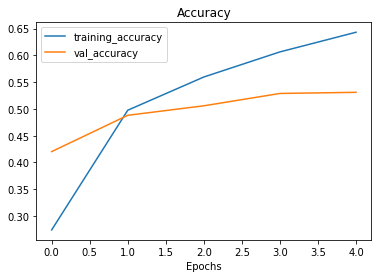

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

### Fine Tuning

In [ ]:
# Unfreeze layers
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
#recompile
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), 
              metrics=['accuracy'])

In [ ]:
#check for trainable layers
for layer in model.layers:
  print(layer.name, layer.trainable)

print('\n')
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation 

In [ ]:
#training again for 5 more epochs
fine_tune_epochs = 10 

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), 
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) 

Epoch 5/10


237/237 [==============================] - 99s 366ms/step - loss: 1.2025 - accuracy: 0.6811 - val_loss: 1.7397 - val_accuracy: 0.5384
Epoch 6/10
237/237 [==============================] - 83s 350ms/step - loss: 1.0844 - accuracy: 0.7137 - val_loss: 1.6916 - val_accuracy: 0.5490
Epoch 7/10
237/237 [==============================] - 84s 351ms/step - loss: 1.0060 - accuracy: 0.7325 - val_loss: 1.6965 - val_accuracy: 0.5511
Epoch 8/10
237/237 [==============================] - 78s 325ms/step - loss: 0.9551 - accuracy: 0.7497 - val_loss: 1.7631 - val_accuracy: 0.5350
Epoch 9/10
237/237 [==============================] - 77s 321ms/step - loss: 0.8940 - accuracy: 0.7584 - val_loss: 1.6865 - val_accuracy: 0.5583
Epoch 10/10
237/237 [==============================] - 75s 317ms/step - loss: 0.8246 - accuracy: 0.7823 - val_loss: 1.7423 - val_accuracy: 0.5477


In [ ]:
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 61s 77ms/step - loss: 1.4966 - accuracy: 0.6047


[1.4966248273849487, 0.6046732664108276]

* we got a slight boost from the previous model

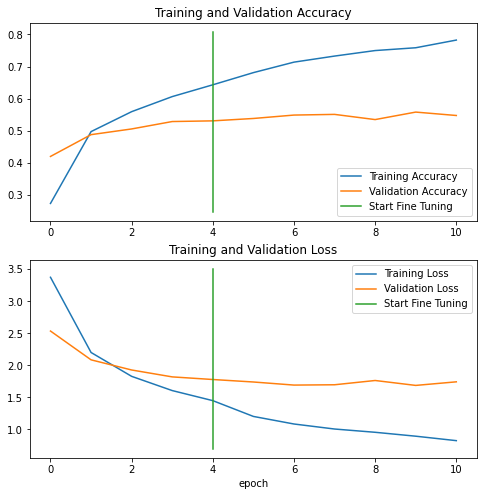

In [ ]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

### Evaluating Model performance

In [ ]:
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 69s 86ms/step


In [ ]:
pred_probs.shape

(25250, 101)

In [ ]:
pred_probs[:10]

array([[2.5590459e-01, 2.2085971e-04, 8.6866774e-02, ..., 9.9502286e-06,
        3.1562941e-03, 7.0101949e-03],
       [9.4575155e-01, 1.2961946e-08, 6.7969208e-04, ..., 6.8052453e-03,
        2.1288184e-07, 9.3122526e-06],
       [5.0933057e-01, 4.5294613e-03, 1.0179360e-02, ..., 2.8339430e-04,
        4.4171841e-04, 1.2909992e-03],
       ...,
       [2.2822860e-01, 8.6822047e-06, 1.8799442e-03, ..., 8.5961834e-02,
        1.9898642e-04, 9.8634191e-05],
       [2.1440472e-01, 1.3477384e-04, 1.9668320e-01, ..., 3.0875779e-04,
        1.9570674e-04, 8.0783531e-05],
       [5.2844387e-01, 2.3515591e-07, 1.9960869e-03, ..., 9.5116803e-03,
        2.1631672e-06, 9.8362274e-04]], dtype=float32)

In [ ]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([ 0,  0,  0,  8,  0, 78, 29,  0,  9,  0])

In [ ]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) 
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6046732673267327

In [ ]:
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

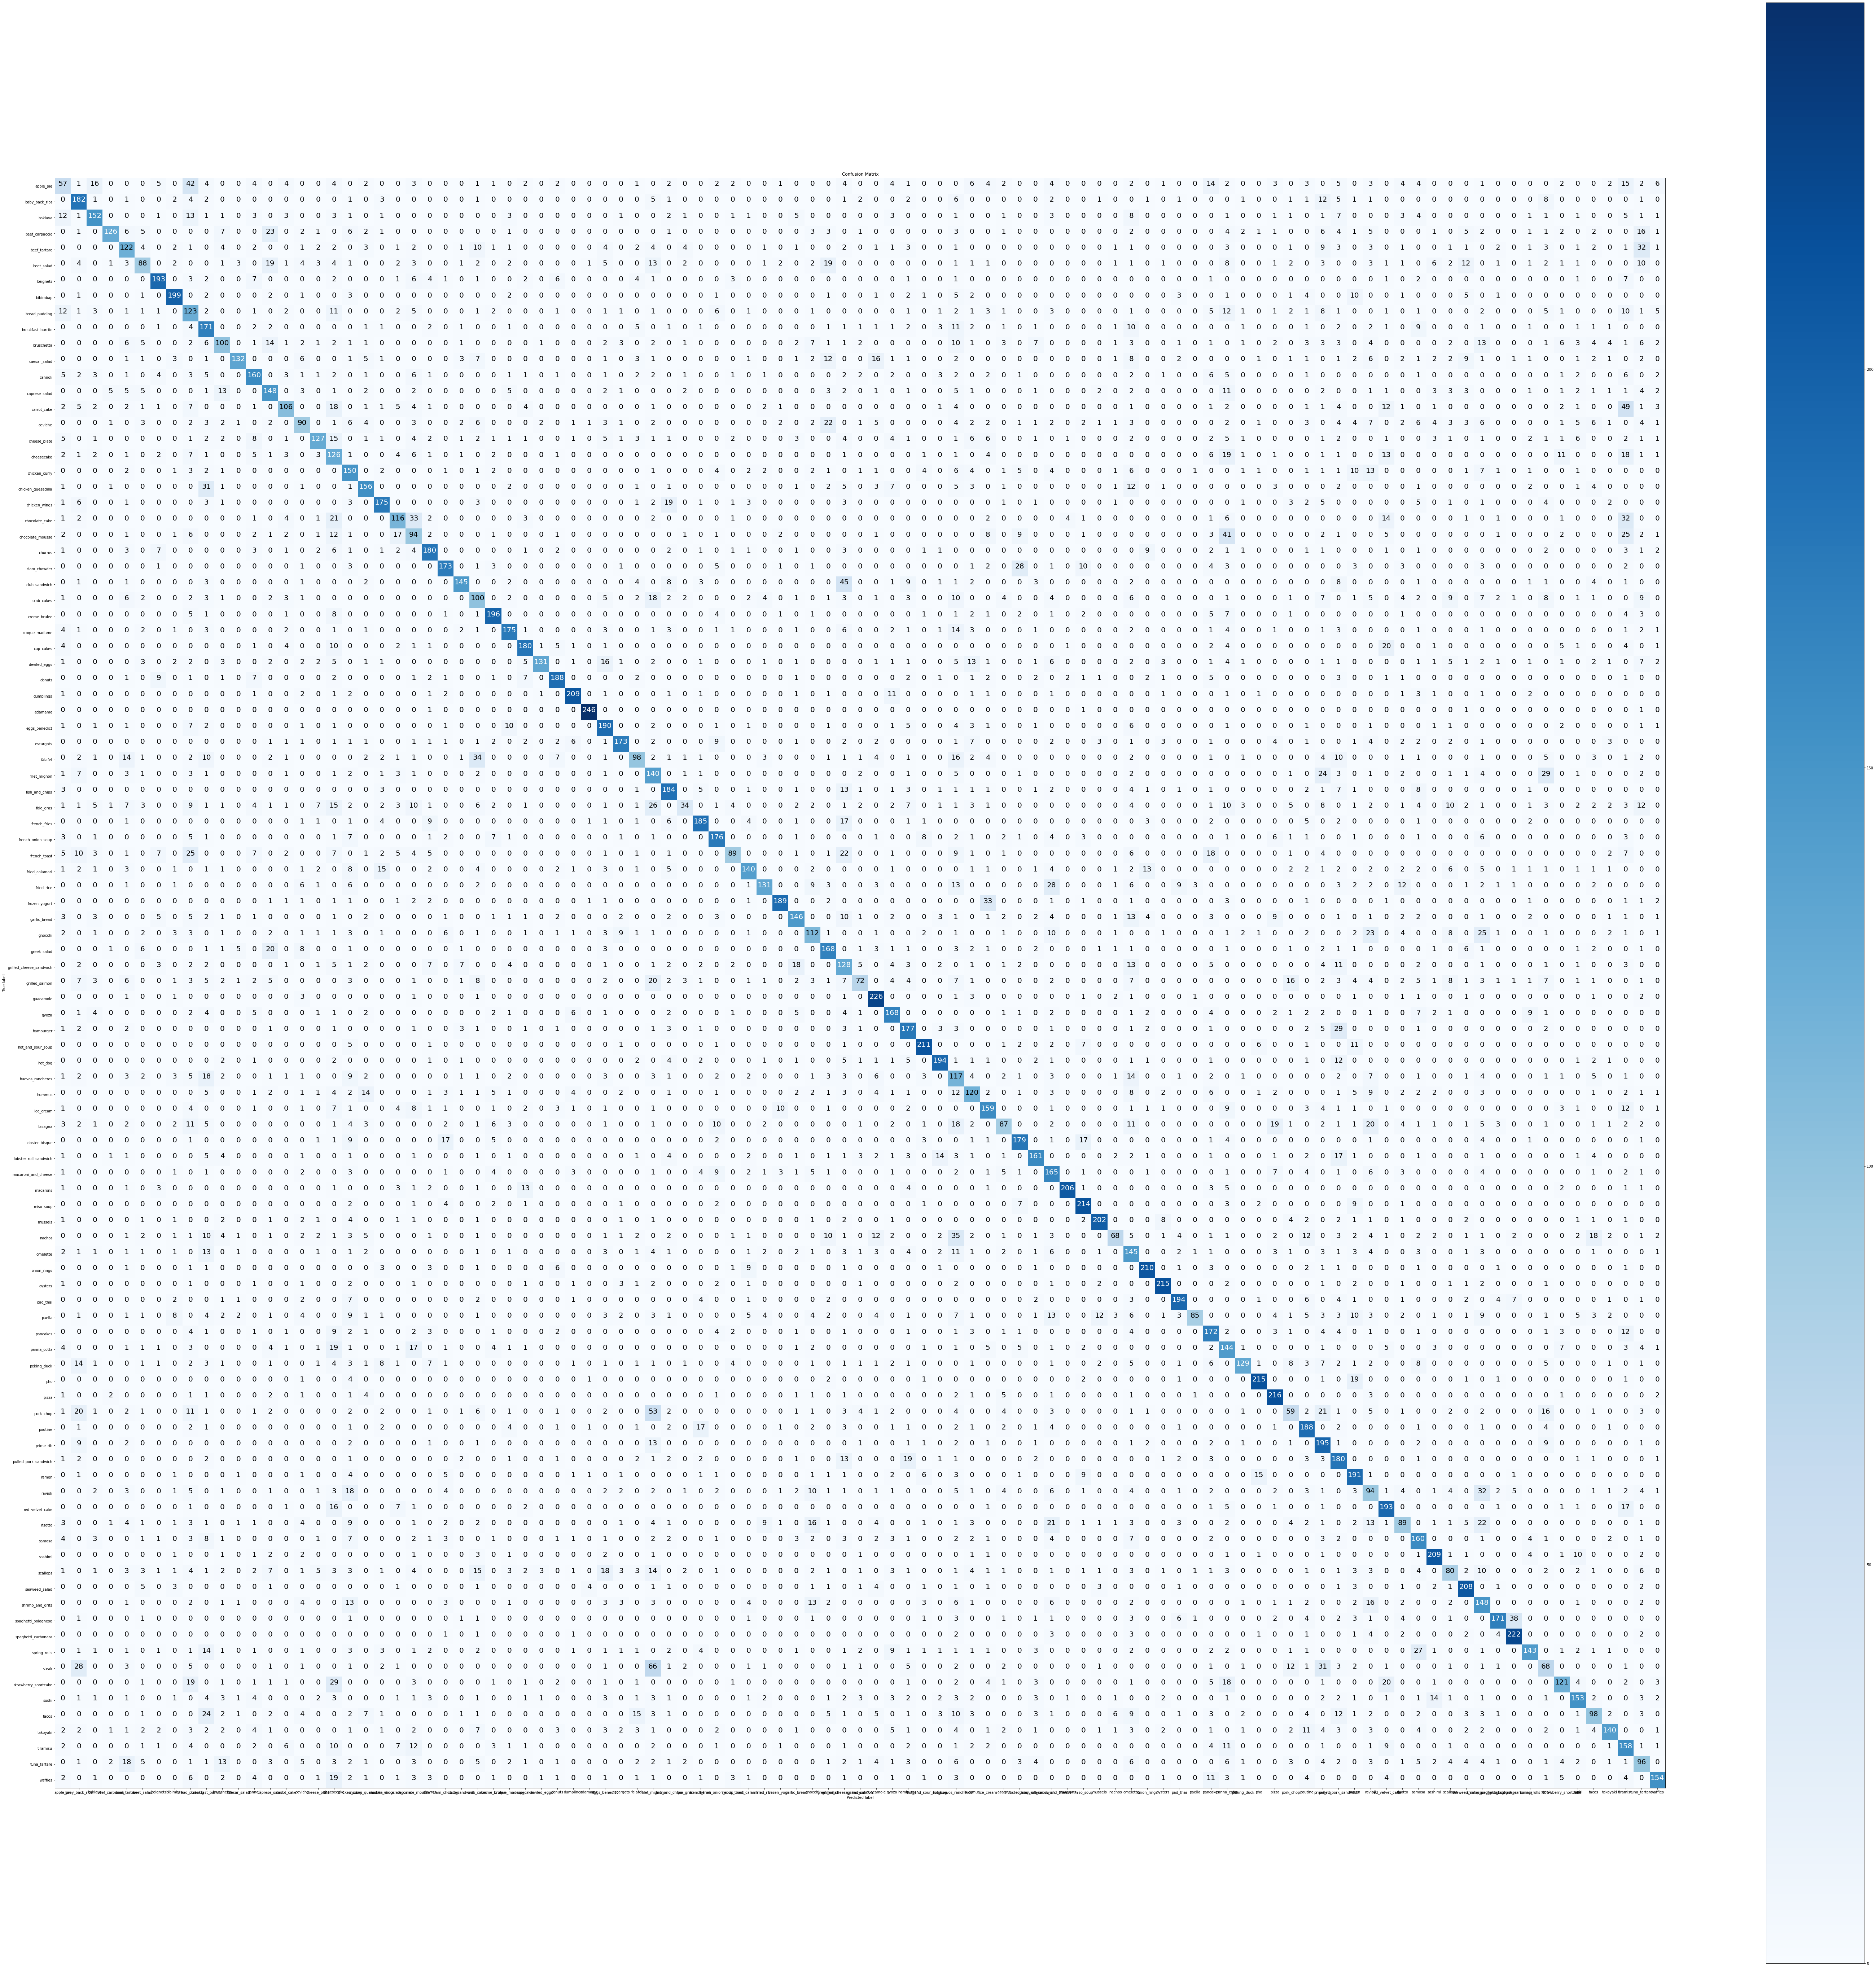

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.34      0.23      0.27       250
           1       0.55      0.73      0.63       250
           2       0.70      0.61      0.65       250
           3       0.88      0.50      0.64       250
           4       0.48      0.49      0.48       250
           5       0.53      0.35      0.42       250
           6       0.77      0.77      0.77       250
           7       0.80      0.80      0.80       250
           8       0.31      0.49      0.38       250
           9       0.42      0.68      0.52       250
          10       0.52      0.40      0.45       250
          11       0.87      0.53      0.66       250
          12       0.63      0.64      0.63       250
          13       0.52      0.59      0.56       250
          14       0.66      0.42      0.52       250
          15       0.49      0.36      0.42       250
          16       0.72      0.51      0.60       250
          17       0.29    

In [ ]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3433734939759036,
  'recall': 0.228,
  'f1-score': 0.2740384615384615,
  'support': 250},
 '1': {'precision': 0.5515151515151515,
  'recall': 0.728,
  'f1-score': 0.6275862068965518,
  'support': 250},
 '2': {'precision': 0.7037037037037037,
  'recall': 0.608,
  'f1-score': 0.6523605150214592,
  'support': 250},
 '3': {'precision': 0.8811188811188811,
  'recall': 0.504,
  'f1-score': 0.6412213740458015,
  'support': 250},
 '4': {'precision': 0.47843137254901963,
  'recall': 0.488,
  'f1-score': 0.48316831683168315,
  'support': 250},
 '5': {'precision': 0.5333333333333333,
  'recall': 0.352,
  'f1-score': 0.4240963855421686,
  'support': 250},
 '6': {'precision': 0.7689243027888446,
  'recall': 0.772,
  'f1-score': 0.7704590818363274,
  'support': 250},
 '7': {'precision': 0.8024193548387096,
  'recall': 0.796,
  'f1-score': 0.7991967871485943,
  'support': 250},
 '8': {'precision': 0.30673316708229426,
  'recall': 0.492,
  'f1-score': 0.3778801843317972,
  'suppo

In [ ]:
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k == "accuracy": 
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.2740384615384615,
 'baby_back_ribs': 0.6275862068965518,
 'baklava': 0.6523605150214592,
 'beef_carpaccio': 0.6412213740458015,
 'beef_tartare': 0.48316831683168315,
 'beet_salad': 0.4240963855421686,
 'beignets': 0.7704590818363274,
 'bibimbap': 0.7991967871485943,
 'bread_pudding': 0.3778801843317972,
 'breakfast_burrito': 0.5221374045801527,
 'bruschetta': 0.45146726862302483,
 'caesar_salad': 0.6567164179104478,
 'cannoli': 0.634920634920635,
 'caprese_salad': 0.5553470919324578,
 'carrot_cake': 0.5170731707317072,
 'ceviche': 0.4157043879907621,
 'cheese_plate': 0.596244131455399,
 'cheesecake': 0.37168141592920356,
 'chicken_curry': 0.4893964110929853,
 'chicken_quesadilla': 0.6432989690721649,
 'chicken_wings': 0.7113821138211383,
 'chocolate_cake': 0.5237020316027088,
 'chocolate_mousse': 0.3650485436893203,
 'churros': 0.7072691552062869,
 'clam_chowder': 0.7090163934426229,
 'club_sandwich': 0.675990675990676,
 'crab_cakes': 0.3952569169960474,
 'creme_brulee'

In [ ]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

class_name  f1-score
33           edamame  0.970414
63          macarons  0.886022
69           oysters  0.863454
75               pho  0.861723
32         dumplings  0.847870
..               ...       ...
56  huevos_rancheros  0.335725
77         pork_chop  0.301790
93             steak  0.300885
0          apple_pie  0.274038
39         foie_gras  0.218650

[101 rows x 2 columns]

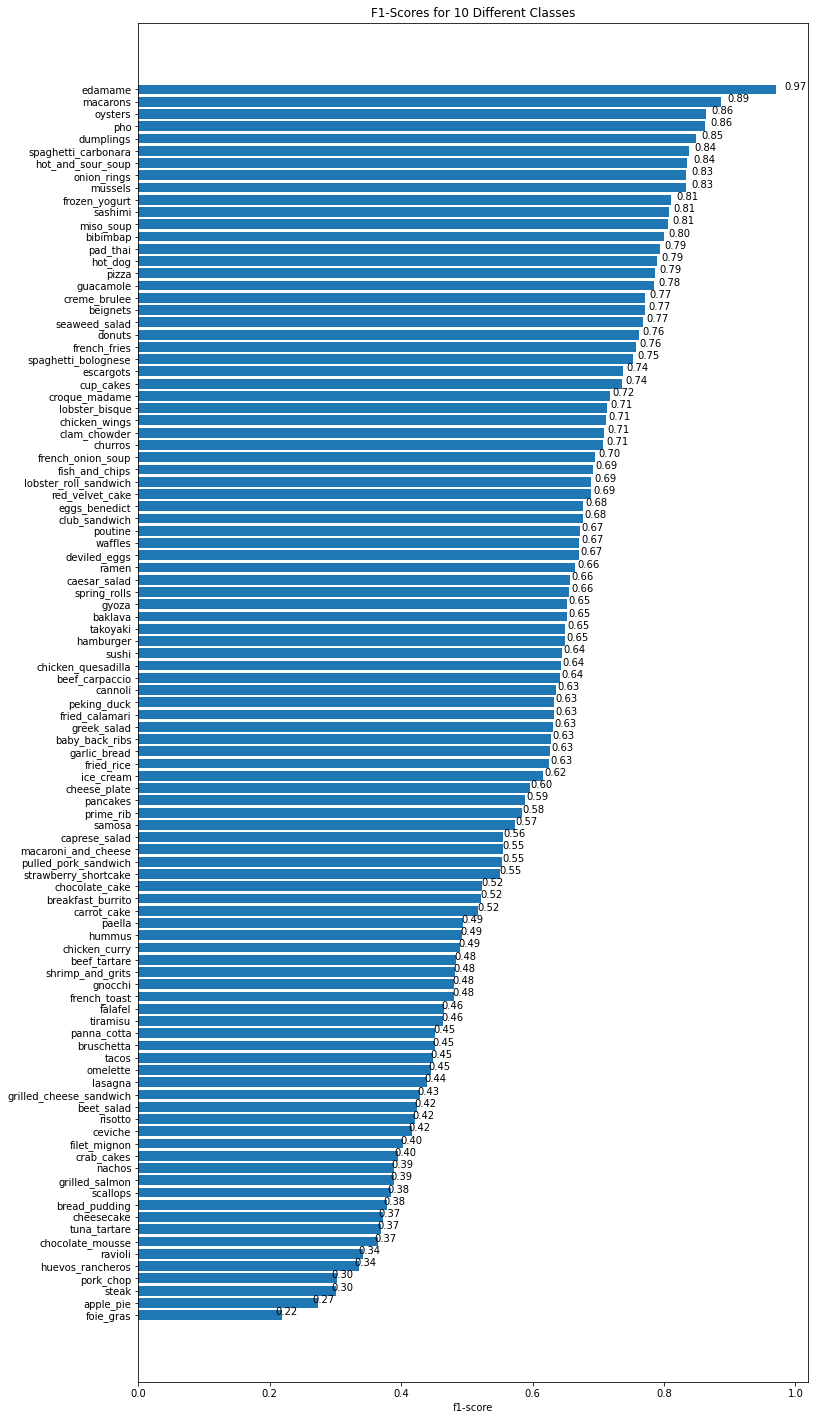

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); 

def autolabel(rects): 
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

### Making predictions on random images

1/1 [==============================] - 0s 44ms/step


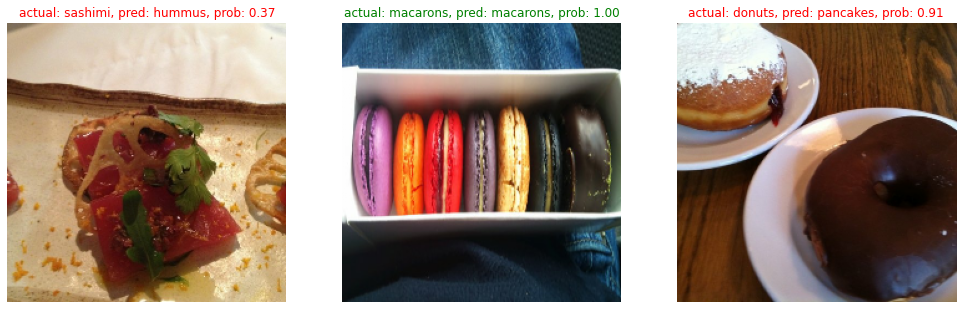

In [ ]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) 
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) 
  pred_class = class_names[pred_prob.argmax()] 

  # Plot the image(s)
  plt.subplot(1,3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

1/1 [==============================] - 0s 39ms/step


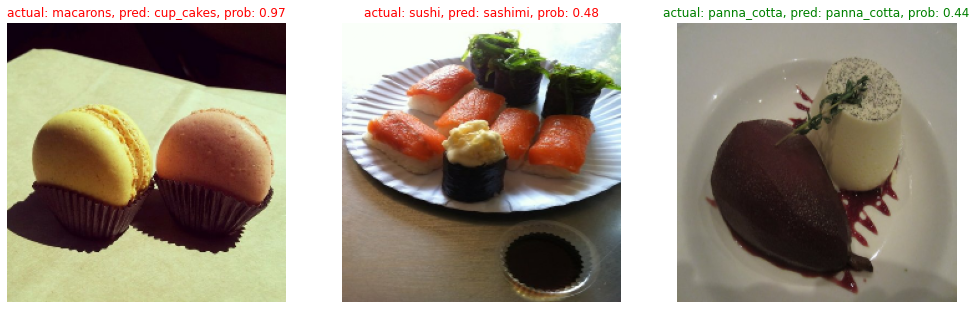

In [ ]:
plt.figure(figsize=(17, 10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) 
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) 
  pred_class = class_names[pred_prob.argmax()] 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

### Most wrong predictions

In [ ]:
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   

   pred_conf y_true_classname y_pred_classname  
0   0.255905        apple_pie        apple_pie  
1   0.945752        apple_pie        apple_pie  
2   0.509331        apple_pie        apple_pie  
3   0.209788        apple_pie    bread_pudding  
4   0.331311        apple_pie        apple_pie

In [ ]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.255905        apple_pie        apple_pie          True  
1   0.945752        apple_pie        apple_pie          True  
2   0.509331        apple_pie        apple_pie          True  
3   0.209788        apple_pie    bread_pudding         False  
4   0.331311        apple_pie        apple_pie          True

In [ ]:
# top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
5114   b'101_food_classes_10_percent/test/chicken_win...      20      38   
9326   b'101_food_classes_10_percent/test/filet_migno...      37      79   
18807  b'101_food_classes_10_percent/test/pho/1713987...      75      98   
191    b'101_food_classes_10_percent/test/apple_pie/3...       0      31   
7194   b'101_food_classes_10_percent/test/croque_mada...      28       7   
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
14630  b'101_food_classes_10_percent/test/ice_cream/3...      58      78   
10880  b'101_food_classes_10_percent/test/fried_calam...      43      68   
722    b'101_food_classes_10_percent/test/baklava/640...       2      85   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
10013  b'101_food_classes_10_percent/test/french_frie...      40      43   
15142  b'101_food_classes_10_percent/test/lobster_bis...      60      64   
23300  b'101_food_classes_10_percent/test/steak/17945...      93       1   
10346  b'101_food_classes_10_percent/test/french_onio...      41      54   
5849   b'101_food_classes_10_percent/test/churros/254...      23      68   
14482  b'101_food_classes_10_percent/test/hummus/8476...      57      51   

       pred_conf   y_true_classname   y_pred_classname  pred_correct  
23797   0.998121              sushi            sashimi         False  
18001   0.997268           pancakes           omelette         False  
11642   0.997222       garlic_bread         bruschetta         False  
5114    0.996684      chicken_wings     fish_and_chips         False  
9326    0.996373       filet_mignon          prime_rib         False  
18807   0.996172                pho           tiramisu         False  
191     0.995450          apple_pie             donuts         False  
7194    0.994489      croque_madame           bibimbap         False  
21810   0.994144           scallops          cup_cakes         False  
14630   0.994115          ice_cream            poutine         False  
10880   0.993104     fried_calamari        onion_rings         False  
722     0.992757            baklava             samosa         False  
10847   0.992539     fried_calamari        onion_rings         False  
17855   0.992486             paella            mussels         False  
10013   0.992126       french_fries     fried_calamari         False  
15142   0.991938     lobster_bisque          miso_soup         False  
23300   0.991572              steak     baby_back_ribs         False  
10346   0.991556  french_onion_soup  hot_and_sour_soup         False  
5849    0.991502            churros        onion_rings         False  
14482   0.990625             hummus          guacamole         False

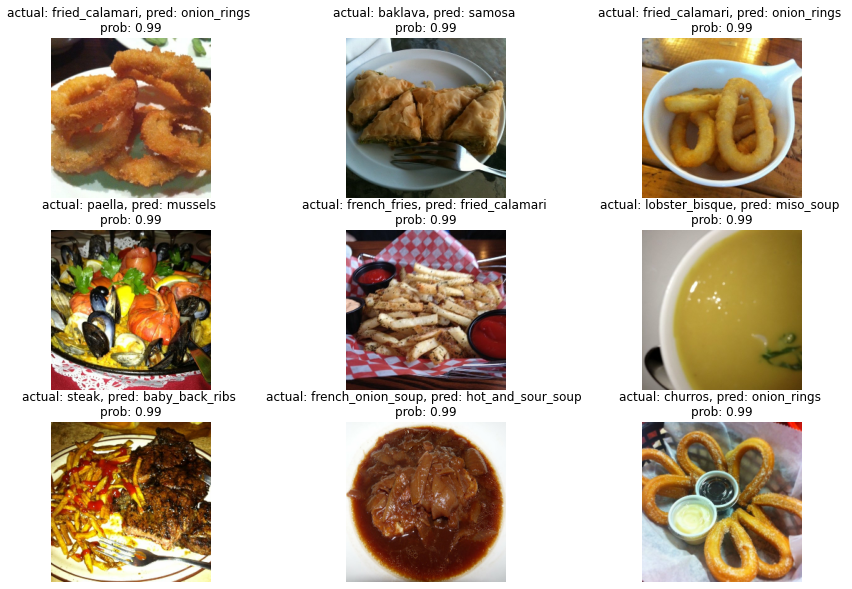

In [ ]:
images_to_view = 9
start_index = 10 
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row 
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

### Testing model on custom images

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip") 

--2023-03-12 07:59:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  5.65MB/s    in 2.2s    

2023-03-12 07:59:21 (5.65 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images
     

['custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg']

1/1 [==============================] - 0s 30ms/step


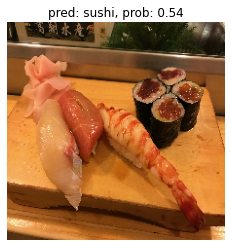

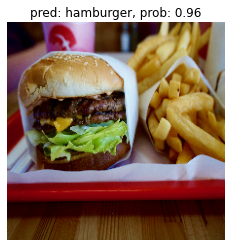

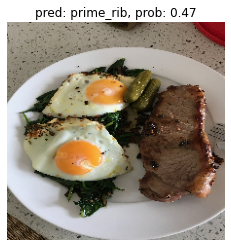

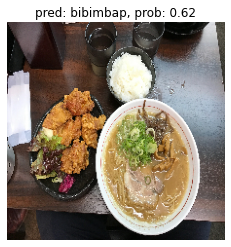

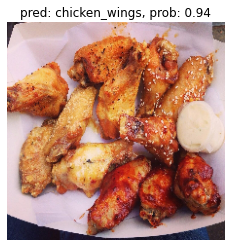

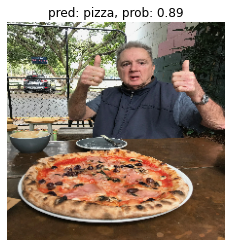

In [ ]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) 
  pred_class = class_names[pred_prob.argmax()] 
  plt.figure()
  plt.imshow(img/255.) 
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

# Training and Testing Model with full 100% data

### Getting Dataset from tensorflow datasets

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
(train_data, test_data), ds_info = tfds.load(name="food101", 
                                             split=["train", "validation"], 
                                             shuffle_files=True, 
                                             as_supervised=True, 
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteY9T6IG/food101-train.tfrecord*...:   0%|          …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteY9T6IG/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

### checking shape of images

In [ ]:
#getting class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
train_one_sample = train_data.take(1)
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 23
  Class name (str form): churros
        


In [ ]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[189, 165, 121],
        [185, 161, 117],
        [181, 157, 113],
        ...,
        [111,  72,  33],
        [103,  64,  25],
        [ 94,  55,  16]],

       [[186, 162, 118],
        [183, 159, 115],
        [180, 156, 112],
        ...,
        [122,  83,  40],
        [113,  74,  31],
        [105,  66,  23]],

       [[180, 156, 112],
        [178, 154, 110],
        [177, 153, 109],
        ...,
        [132,  94,  45],
        [124,  87,  35],
        [120,  83,  31]],

       ...,

       [[207, 204, 159],
        [205, 201, 154],
        [204, 196, 147],
        ...,
        [231, 225, 191],
        [231, 225, 189],
        [231, 226, 188]],

       [[207, 204, 159],
        [205, 201, 154],
        [204, 196, 147],
        ...,
        [230, 224, 190],
        [230, 224, 188],
        [229, 223, 187]],

       [[206, 203, 158],
        [204, 200, 153],
        [203, 195, 146],
        ...,
        [229, 223, 18

### Plotting the image

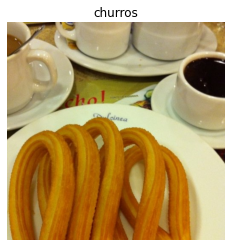

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

### Preprocessing functions

In [ ]:
def preprocess_img(image, label, img_shape=224):
    image = tf.image.resize(image, [img_shape, img_shape]) 
    return tf.cast(image, tf.float32), label 

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[189 165 121]
  [185 161 117]
  [181 157 113]
  ...
  [111  72  33]
  [103  64  25]
  [ 94  55  16]]

 [[186 162 118]
  [183 159 115]
  [180 156 112]
  ...
  [122  83  40]
  [113  74  31]
  [105  66  23]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[184.91327  160.91327  116.91326 ]
  [180.35715  156.35715  112.35714 ]
  [183.71428  160.71428  118.71429 ]
  ...
  [147.5915   108.66289   69.08129 ]
  [123.576454  84.576454  44.198887]
  [106.44359   67.44359   25.872158]]

 [[174.66837  150.66837  106.668365]
  [175.14285  151.14285  107.14286 ]
  [177.80103  153.22958  112.015305]
  ...
  [155.61722  119.545784  68.443695]
  [145.1989   108.19381   53.423363]
  [134.37747   98.30605   40.73462 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


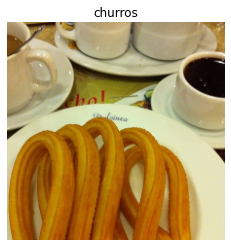

In [ ]:
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

### Preparing Dataset

In [ ]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
checkpoint_path = "model_checkpoints/cp.ckpt" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True, 
                                                      save_weights_only=True,
                                                      verbose=0)  

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

### Creating a base model

In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False 

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False) 
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) 
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [ ]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
for layer in model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float

In [ ]:
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230312-082747
Epoch 1/3
2368/2368 [==============================] - 233s 93ms/step - loss: 1.7205 - accuracy: 0.5807 - val_loss: 1.1276 - val_accuracy: 0.6997
Epoch 2/3
2368/2368 [==============================] - 195s 82ms/step - loss: 1.2001 - accuracy: 0.6883 - val_loss: 1.0431 - val_accuracy: 0.7124
Epoch 3/3
2368/2368 [==============================] - 196s 82ms/step - loss: 1.0551 - accuracy: 0.7233 - val_loss: 0.9870 - val_accuracy: 0.7349


In [ ]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 59s 74ms/step - loss: 0.9992 - accuracy: 0.7292


[0.9991878271102905, 0.7292277216911316]

In [ ]:
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [ ]:
checkpoint_path

'model_checkpoints/cp.ckpt'

In [ ]:
cloned_model.load_weights(checkpoint_path)

In [ ]:
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 61s 74ms/step - loss: 1.3605 - accuracy: 0.6367


In [ ]:
for layer in cloned_model.layers[1].layers[:20]: # check only the first 20 layers
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 True float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float3

### Fine Tuning

In [ ]:
fine_tuned_model = cloned_model

In [ ]:
#cheking for frozen layers
for layer in fine_tuned_model.layers:
    layer.trainable = True 
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

NameError: ignored

In [ ]:
for layer in fine_tuned_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

NameError: ignored

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3) 

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1, 
                                                 min_lr=1e-7)

In [ ]:
#compiling the model
fine_tuned_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

NameError: ignored

In [ ]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = fine_tuned_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

NameError: ignored

In [ ]:
fine_tuned_model.summary()

NameError: ignored

In [ ]:
results_fine_tuned_model = fine_tuned_model.evaluate(test_data)
results_fine_tuned_model

NameError: ignored